In [1]:
# !wget http://baidudeeplearning.bj.bcebos.com/image_contest_level_1.tar.gz
# !tar -zxf image_contest_level_1.tar.gz

In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
import cv2
import time

/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
directory = 'image_contest_level_1/'
images = ['%d.png'%(d) for d in range(100000)]
with open(directory+'labels.txt','r') as fopen:
    labels = [i.split()[0] for i in list(filter(None,fopen.read().split('\n')))]
len(images)
len(labels)

100000

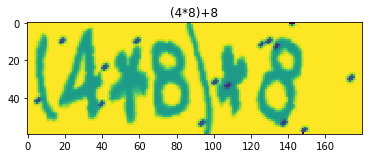

In [4]:
plt.imshow(cv2.imread(directory+images[0], 0).astype(np.float32)/255.)
plt.title(labels[0])
plt.show()

In [5]:
charset = '0123456789+-*()'
num_classes = len(charset) + 2
encode_maps = {}
decode_maps = {}
for i, char in enumerate(charset, 1):
    encode_maps[char] = i
    decode_maps[i] = char

SPACE_INDEX = 0
SPACE_TOKEN = ''
encode_maps[SPACE_TOKEN] = SPACE_INDEX
decode_maps[SPACE_INDEX] = SPACE_TOKEN

In [6]:
image_height = 60
image_width = 240
image_channel = 1
max_stepsize = 128
num_hidden = 256
epoch = 20
batch_size = 128
initial_learning_rate = 1e-3

In [7]:
def pad_second_dim(x, desired_size):
    padding = tf.tile([[0]], tf.stack([tf.shape(x)[0], desired_size - tf.shape(x)[1]], 0))
    return tf.concat([x, padding], 1)

class Model:
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [None, image_height, image_width, image_channel])
        self.Y = tf.sparse_placeholder(tf.int32)
        self.SEQ_LEN = tf.placeholder(tf.int32, [None])
        self.label = tf.placeholder(tf.int32, [None, None])
        self.Y_seq_len = tf.placeholder(tf.int32, [None])
        batch_size = tf.shape(self.X)[0]
        filters = [64, 128, 128, max_stepsize]
        strides = [1, 2]
        x = self.conv2d(self.X, 'cnn-1', 3, 1, filters[0], strides[0])
        x = self.batch_norm('bn1', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-2', 3, filters[0], filters[1], strides[0])
        x = self.batch_norm('bn2', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-3', 3, filters[1], filters[2], strides[0])
        x = self.batch_norm('bn3', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-4', 3, filters[2], filters[3], strides[0])
        x = self.batch_norm('bn4', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = tf.reshape(x, [batch_size, -1, filters[3]])
        x = tf.transpose(x, [0, 2, 1])
        x = tf.reshape(x, [batch_size, filters[3], 4 * 15])
        cell = tf.contrib.rnn.LSTMCell(num_hidden)
        cell1 = tf.contrib.rnn.LSTMCell(num_hidden)
        stack = tf.contrib.rnn.MultiRNNCell([cell, cell1])
        outputs, _ = tf.nn.dynamic_rnn(stack, x, self.SEQ_LEN, dtype=tf.float32)
        outputs = tf.reshape(outputs, [-1, num_hidden])
        self.logits = tf.layers.dense(outputs, num_classes)
        shape = tf.shape(x)
        self.logits = tf.reshape(self.logits, [shape[0], -1, num_classes])
        self.logits = tf.transpose(self.logits, (1, 0, 2))
        self.global_step = tf.Variable(0, trainable=False)
        self.loss = tf.nn.ctc_loss(labels=self.Y,
                                   inputs=self.logits,
                                   sequence_length=self.SEQ_LEN)
        self.cost = tf.reduce_mean(self.loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate).minimize(self.cost)
        self.decoded, self.log_prob = tf.nn.ctc_beam_search_decoder(self.logits,
                                                                    self.SEQ_LEN,
                                                                    merge_repeated=False)
        decoded = tf.to_int32(self.decoded[0])
        self.dense_decoded = tf.sparse_tensor_to_dense(decoded)
        
        preds = self.dense_decoded[:, :tf.reduce_max(self.Y_seq_len)]
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        preds = pad_second_dim(preds, tf.reduce_max(self.Y_seq_len))
        y_t = tf.cast(preds, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(self.label, masks)
        self.mask_label = mask_label
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        
    def conv2d(self, x, name, filter_size, channel_in, channel_out, strides):
        with tf.variable_scope(name):
            return tf.layers.conv2d(x, channel_out, filter_size, strides, padding='SAME')
        
    
    def batch_norm(self, name, x):
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[-1]]
            beta = tf.get_variable('beta', params_shape, tf.float32,
                                   initializer=tf.constant_initializer(0.0, tf.float32))
            gamma = tf.get_variable('gamma', params_shape, tf.float32,
                                    initializer=tf.constant_initializer(1.0, tf.float32))
            mean, variance = tf.nn.moments(x, [0, 1, 2], name='moments')
            x_bn = tf.nn.batch_normalization(x, mean, variance, beta, gamma, 0.001)
            x_bn.set_shape(x.get_shape())
            return x_bn
        
    def leaky_relu(self, x, leak=0):
        return tf.where(tf.less(x, 0.0), leak * x, x, name='leaky_relu')
    
    def max_pool(self, x, size, strides):
        return tf.nn.max_pool(x, 
                              ksize=[1, size, size, 1],
                              strides=[1, strides, strides, 1],
                              padding='SAME',
                              name='max_pool')

In [8]:
def sparse_tuple_from_label(sequences, dtype=np.int32):
    indices, values = [], []
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    return indices, values, shape


def pad_sentence_batch(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = max([len(sentence) for sentence in sentence_batch])
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(len(sentence))
    return padded_seqs, seq_lens

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())

W0829 22:51:45.737936 139691927603008 deprecation.py:323] From <ipython-input-7-87943060143a>:69: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0829 22:51:45.743227 139691927603008 deprecation.py:506] From /home/husein/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0829 22:51:45.988447 139691927603008 deprecation.py:506] From <ipython-input-7-87943060143a>:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing

In [10]:
from tqdm import tqdm

X, Y = [], []
for i in tqdm(range(len(images))):
    img = images[i]
    X.append(imresize(cv2.imread(directory+img, 0).astype(np.float32)/255., (image_height,image_width)))
    Y.append([SPACE_INDEX if labels[0] == SPACE_TOKEN else encode_maps[c] for c in labels[i]])

100%|██████████| 100000/100000 [02:43<00:00, 610.59it/s]


In [11]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.2)

In [12]:
for e in range(epoch):
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'minibatch loop')
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    total_lost, total_acc = 0, 0
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = train_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss, _ = sess.run([model.accuracy,model.cost,model.optimizer],
                                    feed_dict = feed)
        train_loss.append(loss)
        train_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
        
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'minibatch loop')
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = test_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss = sess.run([model.accuracy,model.cost],
                                    feed_dict = feed)

        test_loss.append(loss)
        test_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    print('epoch %d, training avg loss %f, training avg acc %f'%(e+1,
                                                                 np.mean(train_loss),np.mean(train_acc)))
    print('epoch %d, testing avg loss %f, testing avg acc %f'%(e+1,
                                                              np.mean(test_loss),np.mean(test_acc)))

minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1, training avg loss 13.664520, training avg acc 0.256896
epoch 1, testing avg loss 7.003703, testing avg acc 0.596915


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2, training avg loss 3.353983, training avg acc 0.815715
epoch 2, testing avg loss 0.913711, testing avg acc 0.958989


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3, training avg loss 0.431414, training avg acc 0.981401
epoch 3, testing avg loss 0.203769, testing avg acc 0.988942


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4, training avg loss 0.146375, training avg acc 0.993252
epoch 4, testing avg loss 0.130219, testing avg acc 0.992678


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5, training avg loss 0.096891, training avg acc 0.995104
epoch 5, testing avg loss 0.119220, testing avg acc 0.992331


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6, training avg loss 0.085956, training avg acc 0.995440
epoch 6, testing avg loss 0.136504, testing avg acc 0.992477


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7, training avg loss 0.065135, training avg acc 0.996399
epoch 7, testing avg loss 0.076356, testing avg acc 0.995863


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8, training avg loss 0.058813, training avg acc 0.996647
epoch 8, testing avg loss 0.079129, testing avg acc 0.995560


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9, training avg loss 0.052637, training avg acc 0.996959
epoch 9, testing avg loss 0.067974, testing avg acc 0.996060


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10, training avg loss 0.051642, training avg acc 0.997049
epoch 10, testing avg loss 0.045224, testing avg acc 0.997184


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11, training avg loss 0.037941, training avg acc 0.997852
epoch 11, testing avg loss 0.110841, testing avg acc 0.993028


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12, training avg loss 0.049097, training avg acc 0.997056
epoch 12, testing avg loss 0.052734, testing avg acc 0.996672


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13, training avg loss 0.027234, training avg acc 0.998494
epoch 13, testing avg loss 0.101270, testing avg acc 0.994909


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14, training avg loss 0.036998, training avg acc 0.997947
epoch 14, testing avg loss 0.048051, testing avg acc 0.997119


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15, training avg loss 0.029729, training avg acc 0.998163
epoch 15, testing avg loss 0.045602, testing avg acc 0.997220


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16, training avg loss 0.028113, training avg acc 0.998413
epoch 16, testing avg loss 0.047610, testing avg acc 0.997440


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17, training avg loss 0.028695, training avg acc 0.998254
epoch 17, testing avg loss 0.028516, testing avg acc 0.998482


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18, training avg loss 0.020355, training avg acc 0.998839
epoch 18, testing avg loss 0.033305, testing avg acc 0.998084


minibatch loop:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19, training avg loss 0.031560, training avg acc 0.998207
epoch 19, testing avg loss 0.060350, testing avg acc 0.996566


minibatch loop: 100%|██████████| 157/157 [03:19<00:00,  1.01it/s, accuracy=0.995, cost=0.054]  

epoch 20, training avg loss 0.016528, training avg acc 0.999112
epoch 20, testing avg loss 0.019961, testing avg acc 0.998736


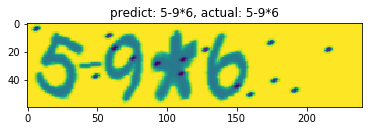

In [15]:
decoded = sess.run(model.dense_decoded, feed_dict = {model.X: batch_x[:1],
                                          model.SEQ_LEN: batch_len[:1]})
plt.imshow(batch_x[0][:,:,0])
decoded = ''.join([decode_maps[i] for i in decoded[0]])
actual = ''.join([decode_maps[i] for i in y[0]])
plt.title('predict: %s, actual: %s'%(decoded, actual))
plt.show()